# Smoothed-gridded seismicity of the Indian Subcontinent

This is an attempt to reproduce the results of Nath & Thingbaijam (2012) since their electronic supplement is in error.

In [1]:
%matplotlib inline
%load_ext autoreload

In [2]:
import os
from copy import deepcopy
from StringIO import StringIO
from IPython.display import display

import numpy as np
import pandas as pd
from scipy import stats
import lxml.etree as et
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

import toolbox as tb
%autoreload 2
import source_model_tools as smt
%autoreload 2
import poisson_test

from openquake.hazardlib import tom, geo
import hmtk.sources as src
%autoreload 2
import hmtk.plotting.seismicity.catalogue_plots as scp

from hmtk.parsers.catalogue import CsvCatalogueParser
from hmtk.plotting.mapping import HMTKBaseMap
%autoreload 2
from hmtk.seismicity.smoothing.smoothed_seismicity import SmoothedSeismicity
%autoreload 2
from hmtk.seismicity.smoothing.kernels.isotropic_gaussian import IsotropicGaussian
%autoreload 2
from hmtk.seismicity.completeness.comp_stepp_1971 import Stepp1971
%autoreload 2
from hmtk.plotting.seismicity.completeness import plot_stepp_1972

from hmtk.seismicity.selector import CatalogueSelector
from hmtk.seismicity.declusterer.dec_afteran import Afteran 
from hmtk.seismicity.declusterer.dec_gardner_knopoff import GardnerKnopoffType1 
from hmtk.seismicity.declusterer.distance_time_windows import (GardnerKnopoffWindow, 
                                                               GruenthalWindow, 
                                                               UhrhammerWindow)

pd.options.display.float_format = lambda x: '%.2g' % x

In [3]:
# define some lists needed at different stages
layer_ids = [1, 2, 3, 4]
layer_depths_km = [0, 25, 70, 180, 300]

df_layers = pd.DataFrame(zip(layer_ids, layer_depths_km[:-1], layer_depths_km[1:]), columns=['id','zmin','zmax'])
display(df_layers)

min_mags = [4.5, 5.5]
corr_dists_km = [65, 85]

df_models = pd.DataFrame(zip(min_mags, corr_dists_km), columns=['min mag','corr dist'])
display(df_models)

,id,zmin,zmax
0,1,0,25
1,2,25,70
2,3,70,180
3,4,180,300


,min mag,corr dist
0,4.5,65
1,5.5,85


In [4]:
# define some input and output filenames
catalogue_txt = '../Catalogue/SACAT1900_2008v2.txt'
catalogue_csv = catalogue_txt.replace('.txt','.csv')
completeness_csv = '../Data/thingbaijam2011seismogenic/Table1.csv'

model_path = '../Data/nath2012probabilistic'
old_txt_template = os.path.join(model_path,'lay%dsmooth%.1f.txt')
recomputed_path = './Recomputed'
large_csv_template = os.path.join(recomputed_path, 'smoothed_seismicity_layer%d_mmin%g.csv')
small_csv_template = os.path.join(recomputed_path, 'smoothed_source_model_mmin_%g_layer_%d.csv')
new_txt_template = os.path.join(recomputed_path, os.path.split(old_txt_template)[1])

In [5]:
# read completeness table
completeness_df = pd.read_csv(completeness_csv, header=[0,1], index_col=[0,1])
completeness_tables = [[[[completeness_df.loc[z_min, z_max][str(mag), 'start'], mag]]
                        for mag in [4.5, 5.5, 5, 6]] 
                       for z_min, z_max in zip(layer_depths_km[:-1], layer_depths_km[1:])]
completeness_df.columns = [' '.join(col).strip() for col in completeness_df.columns.values]
completeness_df.reset_index(inplace=True)
df_layers = pd.merge(completeness_df, df_layers)
display(df_layers)
display(completeness_tables)

,zmin,zmax,4 start,4 end,4.5 start,4.5 end,5.5 start,5.5 end,5 start,5 end,6 start,6 end,id
0,0,25,1994,2008,1964,2008,1903,2008,1964,2008,1964,2008,1
1,25,70,1990,2008,1964,2008,1902,2008,1964,2008,1964,2008,2
2,70,180,1996,2008,1964,2008,1914,2008,1964,2008,1964,2008,3
3,180,300,1970,2008,1984,2008,1912,2008,1984,2008,1984,2008,4


[[[[1964, 4.5]], [[1903, 5.5]], [[1964, 5]], [[1964, 6]]],
 [[[1964, 4.5]], [[1902, 5.5]], [[1964, 5]], [[1964, 6]]],
 [[[1964, 4.5]], [[1914, 5.5]], [[1964, 5]], [[1964, 6]]],
 [[[1984, 4.5]], [[1912, 5.5]], [[1984, 5]], [[1984, 6]]]]

In [119]:
# parse the CSV catalogue
parser = CsvCatalogueParser(catalogue_csv) 
catalogue = parser.read_file() 

print 'Number of entries:', len(catalogue.data['eventID'])
print 'Keys before cleaning:', ', '.join(catalogue.data.keys())

min_lon, max_lon, min_lat, max_lat = catalogue.get_bounding_box()
print 'Longitudes: %g to %g' % (min_lon, max_lon)
print 'Latitudes: %g to %g' % (min_lat, max_lat)

catalogue.sort_catalogue_chronologically()

Catalogue Attribute mag_err is not a recognised catalogue key
Catalogue Attribute nmag_type is not a recognised catalogue key
Catalogue Attribute mag is not a recognised catalogue key
Number of entries: 50331
Keys before cleaning: eventID, comment, sigmaMagnitude, hour, SemiMinor90, magnitude, Agency, second, longitude, month, depthError, flag, depth, magnitudeType, SemiMajor90, timeError, year, latitude, ErrorStrike, day, minute
Longitudes: 55 to 101
Latitudes: 2 to 40


In [120]:
# clean out empty keys allowing easy conversion to dataframe (for ease of display and query)
for key in catalogue.data.keys():
    if len(catalogue.data[key]) == 0:
        catalogue.data.pop(key)
        
# it will be helpful to order the more interesting columns
useful_keys = ['eventID','Agency','comment','layerid',
               'magnitude','sigmaMagnitude',
               'year','month','day','hour','minute','second',
               'longitude','latitude','depth','depthError']

Assigning 878/50331 events without depths to layer 1
Assigning 46/50331 events below 300 km depth to layer 5


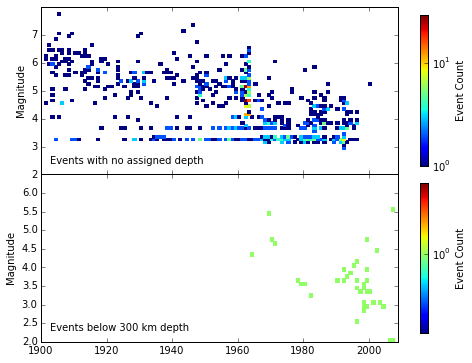

In [121]:
# assign layer ids and study contentious assignments
layer_id_array = np.full_like(catalogue.data['depth'], np.nan)
for _, layer in df_layers.iterrows():
    at_depth = ((catalogue.data['depth'] >= layer['zmin']) & 
                (catalogue.data['depth'] < layer['zmax']))
    layer_id_array[at_depth] = layer['id']

unassigned = catalogue.data['depth'] == -1
too_deep = catalogue.data['depth'] > layer_depths_km[-1]

fig, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
fig.subplots_adjust(hspace=0)

fig.sca(axes[0])
tb.annotate('Events with no assigned depth', loc='lower left')
catalogue_slice = deepcopy(catalogue)
catalogue_slice.select_catalogue_events(unassigned)
scp.plot_magnitude_time_density(catalogue_slice, 0.1, 1)

fig.sca(axes[1])
tb.annotate('Events below %g km depth' % (layer_depths_km[-1]), loc='lower left')
catalogue_slice = deepcopy(catalogue)
catalogue_slice.select_catalogue_events(too_deep)
scp.plot_magnitude_time_density(catalogue_slice, 0.1, 1)
plt.xlim(1900, 2009)
plt.savefig('Unassigned and deep events in raw catalogue.pdf', dpi=300, bbox_inches='tight')

layer_id_array[unassigned] = 1
print 'Assigning %d/%d events without depths to layer 1' % (sum(unassigned), len(unassigned))
layer_id_array[too_deep] = 5
print 'Assigning %d/%d events below %g km depth to layer 5' % (sum(too_deep), len(too_deep), layer_depths_km[-1])
catalogue.data['layerid'] = layer_id_array

In [122]:
#purge events which are too small to be of interest
mag_negligible = 4.
too_small = catalogue.data['magnitude'] <= mag_negligible
catalogue.purge_catalogue(~too_small)
print 'Purged %d/%d events below M=%g' % (sum(too_small), len(too_small), mag_negligible)

Purged 17482/50331 events below M=4


In [123]:
sort_mag = ['magnitude','year','month','day','hour','minute','second']
reverse_mag = [False, True, True, True, True, True, True]

print 'Bottom 5 events:'
display(pd.DataFrame(catalogue.data)[useful_keys].sort(columns=sort_mag).head(5))
print 'Top 10 events:'
display(pd.DataFrame(catalogue.data)[useful_keys].sort(columns=sort_mag, ascending=reverse_mag).head(10))

Bottom 5 events:


,eventID,Agency,comment,layerid,magnitude,sigmaMagnitude,year,month,day,hour,minute,second,longitude,latitude,depth,depthError
13,14,JS2004a,Mainshock,1,4.1,0.46,1903,5,17,-1,-1,-1,80,23,-1,-1
26,29,JS2004a,Mainshock,1,4.1,0.46,1905,4,2,-1,-1,-1,80,16,-1,-1
129,139,JS2004a,Mainshock,1,4.1,0.46,1922,3,13,-1,-1,-1,71,22,-1,-1
173,186,JS2004a,Mainshock,1,4.1,0.46,1927,1,1,-1,-1,-1,83,18,-1,-1
470,510,JS2004a,Mainshock,1,4.1,0.46,1941,5,28,-1,-1,-1,73,18,-1,-1


Top 10 events:


,eventID,Agency,comment,layerid,magnitude,sigmaMagnitude,year,month,day,hour,minute,second,longitude,latitude,depth,depthError
21993,32897,EHB,Mainshock,1,9.1,0.1,2004,12,26,0,58,52,96,3.3,22,0
21994,32898,GCMT,Mainshock,2,9.1,0.1,2004,12,26,1,1,9,94,3.1,29,-1
562,618,T2008a,Mainshock,2,8.6,0.2,1950,8,15,14,9,30,96,28,45,-1
25728,37422,ISC,Aftershock,2,8.6,0.1,2005,3,28,16,9,37,97,2.1,34,0
324,345,SG1980a,Mainshock,2,8.1,0.2,1934,1,15,8,43,-1,87,28,25,-1
506,551,ISC;B1992a,Mainshock,2,8.1,0.2,1945,11,27,21,56,50,63,25,25,-1
75,83,ISC,Mainshock,2,8,0.23,1912,5,23,2,24,6,97,21,35,-1
27,30,W2005a,Mainshock,1,7.8,0.2,1905,4,4,-1,50,-1,76,32,-1,-1
1184,1331,USGS,Mainshock,4,7.8,0.1,1965,3,14,15,53,7.6,71,36,2.1e+02,3.1
19124,26113,EHB,Mainshock,1,7.8,0.1,2001,11,14,9,26,13,91,36,15,0


At a glance, there are 2 mainshocks in the top 10 magnitude events which are actually duplicates (not even aftershocks, but detectable as aftershocks).

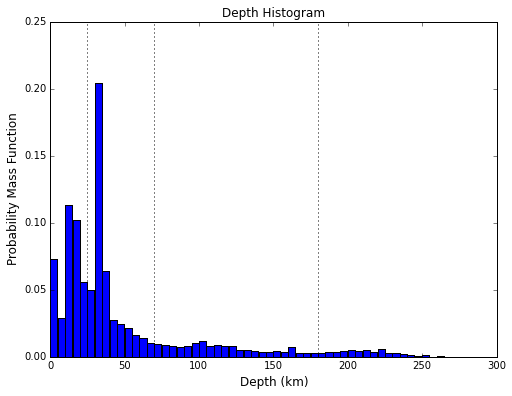

In [155]:
scp.plot_depth_histogram(catalogue, 5, normalisation=True)
plt.xlim(layer_depths_km[0], layer_depths_km[-1])
[plt.axvline(x, color='black', linestyle=':') for x in layer_depths_km];
plt.savefig('Depth histogram (catalogue).pdf', dpi=300, bbox_inches='tight')

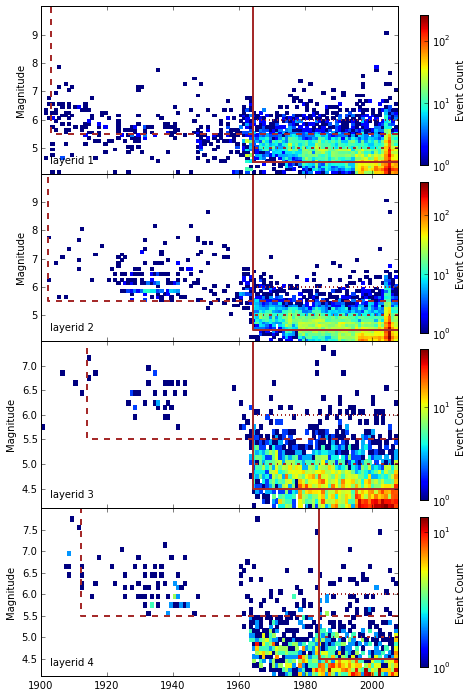

In [163]:
scp.plot_mag_time_density_slices(catalogue, completeness_tables, 'layerid', layer_ids)
plt.xlim(1900, 2008)
plt.savefig('Magnitude time density (catalogue).pdf', dpi=300, bbox_inches='tight')

In [157]:
# implement Nath & Thingbaijam's declustering first
declustered = deepcopy(catalogue)
is_mainshock = [item == 'Mainshock' for item in declustered.data['comment']]
declustered.purge_catalogue(is_mainshock)
print 'Retained', declustered.get_number_events(), 'out of', catalogue.get_number_events(), 'events'

Retained 18763 out of 32849 events


In [158]:
print 'Bottom 5 events:'
display(pd.DataFrame(declustered.data)[useful_keys].sort(columns=sort_mag).head(5))
print 'Top 10 events:'
display(pd.DataFrame(declustered.data)[useful_keys].sort(columns=sort_mag, ascending=reverse_mag).head(10))

Bottom 5 events:


,eventID,Agency,comment,layerid,magnitude,sigmaMagnitude,year,month,day,hour,minute,second,longitude,latitude,depth,depthError
13,14,JS2004a,Mainshock,1,4.1,0.46,1903,5,17,-1,-1,-1,80,23,-1,-1
25,29,JS2004a,Mainshock,1,4.1,0.46,1905,4,2,-1,-1,-1,80,16,-1,-1
118,139,JS2004a,Mainshock,1,4.1,0.46,1922,3,13,-1,-1,-1,71,22,-1,-1
160,186,JS2004a,Mainshock,1,4.1,0.46,1927,1,1,-1,-1,-1,83,18,-1,-1
416,510,JS2004a,Mainshock,1,4.1,0.46,1941,5,28,-1,-1,-1,73,18,-1,-1


Top 10 events:


,eventID,Agency,comment,layerid,magnitude,sigmaMagnitude,year,month,day,hour,minute,second,longitude,latitude,depth,depthError
15843,32897,EHB,Mainshock,1,9.1,0.1,2004,12,26,0,58,52,96,3.3,22,0
15844,32898,GCMT,Mainshock,2,9.1,0.1,2004,12,26,1,1,9,94,3.1,29,-1
482,618,T2008a,Mainshock,2,8.6,0.2,1950,8,15,14,9,30,96,28,45,-1
286,345,SG1980a,Mainshock,2,8.1,0.2,1934,1,15,8,43,-1,87,28,25,-1
446,551,ISC;B1992a,Mainshock,2,8.1,0.2,1945,11,27,21,56,50,63,25,25,-1
68,83,ISC,Mainshock,2,8,0.23,1912,5,23,2,24,6,97,21,35,-1
26,30,W2005a,Mainshock,1,7.8,0.2,1905,4,4,-1,50,-1,76,32,-1,-1
1012,1331,USGS,Mainshock,4,7.8,0.1,1965,3,14,15,53,7.6,71,36,2.1e+02,3.1
13875,26113,EHB,Mainshock,1,7.8,0.1,2001,11,14,9,26,13,91,36,15,0
13877,26115,GCMT,Mainshock,1,7.8,0.1,2001,11,14,9,43,12,92,36,15,-1


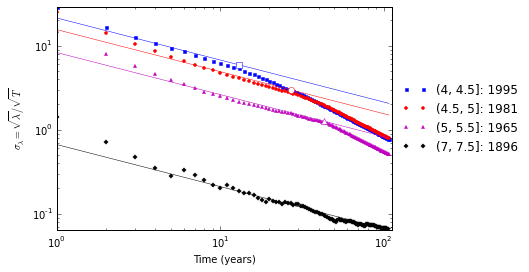

In [159]:
# fit completeness
comp_config = {'magnitude_bin': 0.5, 'time_bin': 1., 'increment_lock': True}
model = Stepp1971()
model.completeness(declustered, comp_config)
model.simplify()

plot_stepp_1972.create_stepp_plot(model)
plt.savefig('Stepp completeness (raw, all layers).pdf', dpi=300, 
            bbox_inches='tight')

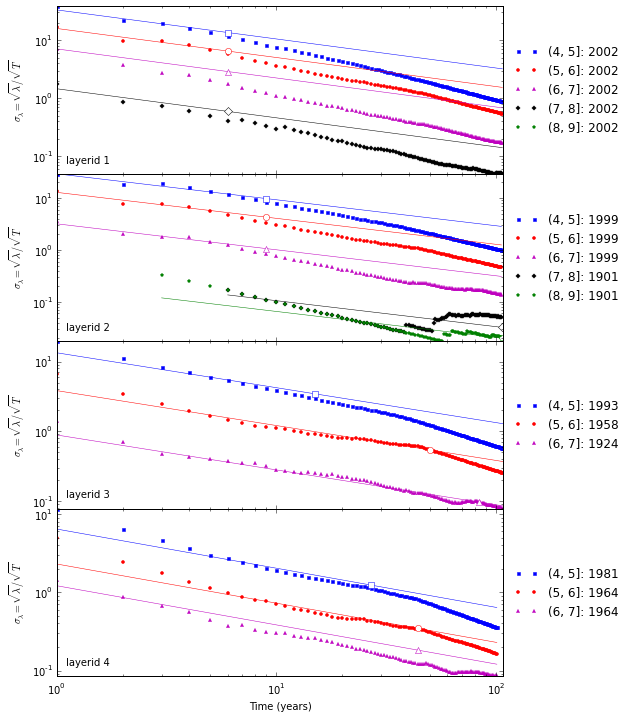

In [164]:
layer_completeness_tables = plot_stepp_1972.plot_completeness_slices(
    catalogue, 'layerid', layer_ids, mag_bin=1., deduplicate=False)
completeness_tables.append(layer_completeness_tables)
plt.savefig('Stepp completeness (mainshocks).pdf', 
            dpi=300, bbox_inches='tight')

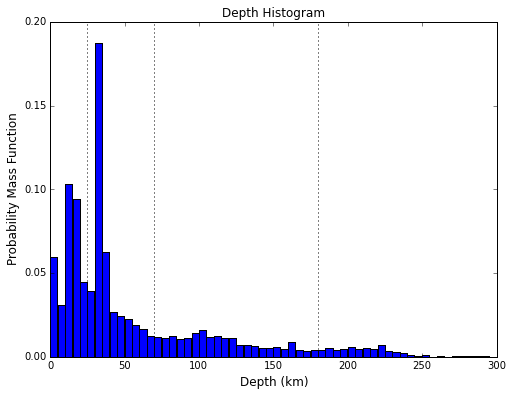

In [132]:
scp.plot_depth_histogram(declustered, 5, normalisation=True)
plt.xlim(layer_depths_km[0], layer_depths_km[-1])
[plt.axvline(x, color='black', linestyle=':') for x in layer_depths_km];
plt.savefig('Depth histogram (mainshocks).pdf', dpi=300, bbox_inches='tight')

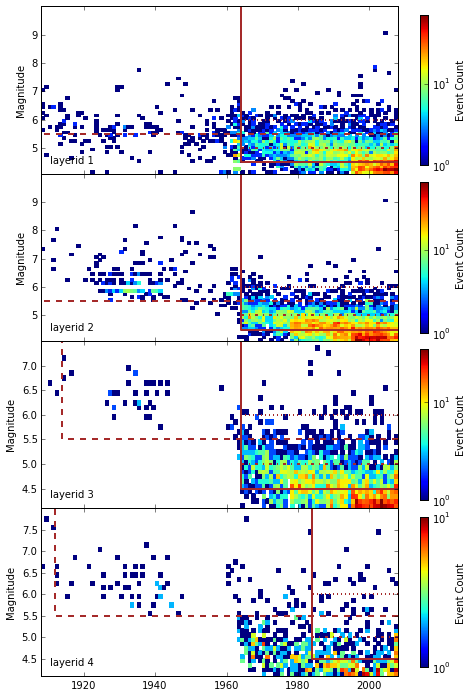

In [133]:
plot_magnitude_time_density_slices(declustered, completeness_tables, 'layerid', layer_ids)
plt.savefig('Magnitude time density (mainshocks).pdf', dpi=300, bbox_inches='tight')

In [166]:
# identify fore/aftershocks among the mainshocks
declust_config_gk = {'time_distance_window': UhrhammerWindow(), 
                     'fs_time_prop': 1.0}
declustering_gk = GardnerKnopoffType1()

declustered.data['cluster index'], declustered.data['cluster flag'] = declustering_gk.decluster(
    declustered, declust_config_gk)
print 'Identified an additional %d foreshocks and %d aftershocks out of %d' % (
    sum(declustered.data['cluster flag'] == -1), 
    sum(declustered.data['cluster flag'] == 1), 
    len(declustered.data['cluster flag']))

# implement declustering from mainshocks
declustered2 = deepcopy(declustered)
declustered2.purge_catalogue(declustered.data['cluster flag'] == 0)
print 'Retained', declustered2.get_number_events(), 'out of', declustered.get_number_events(), 'events'

Identified an additional 1939 foreshocks and 1639 aftershocks out of 18763
Retained 15185 out of 18763 events


In [304]:
def df_diff(df1, df2):
    df1 = pd.DataFrame(df1)
    df2 = pd.DataFrame(df2)
    df_merge = pd.merge(df1[['eventID']], df2[['eventID']], on='eventID')
    matches = [index for index, value in df1['eventID'].iteritems() if value in df_merge['eventID'].values]
    return df1.drop(matches)

In [165]:
# identify fore/aftershocks in the raw catalogue
catalogue.data['cluster index'], catalogue.data['cluster flag'] = declustering_gk.decluster(
    catalogue, declust_config_gk)
print 'Identified %d foreshocks and %d aftershocks out of %d events' % (
    sum(catalogue.data['cluster flag']  == -1), 
    sum(catalogue.data['cluster flag']  == 1), 
    len(catalogue.data['cluster flag'] ))

# implement declustering from raw catalogue
declustered3 = deepcopy(catalogue)
declustered3.purge_catalogue(catalogue.data['cluster flag'] == 0)
print 'Retained', declustered3.get_number_events(), 'out of', catalogue.get_number_events(), 'events'

Identified 3584 foreshocks and 12481 aftershocks out of 32849 events


In [320]:
df_diff23 = df_diff(declustered.data, declustered2.data)
print('Top 10/%d mainshocks removed when declustering from mainshocks:' % len(df_diff23))
display(df_diff23[useful_keys].sort(columns=sort_mag, ascending=reverse_mag).head(10))

Top 10/3578 mainshocks removed when declustering from mainshocks:


,eventID,Agency,comment,layerid,magnitude,sigmaMagnitude,year,month,day,hour,minute,second,longitude,latitude,depth,depthError
15844,32898,GCMT,Mainshock,2,9.1,0.1,2004,12,26,1,1,9,94,3.1,29,-1
13877,26115,GCMT,Mainshock,1,7.8,0.1,2001,11,14,9,43,12,92,36,15,-1
456,564,T2008a,Mainshock,2,7.7,0.4,1947,7,29,13,43,22,94,28,60,-1
63,77,ISC,Mainshock,4,7.5,0.23,1911,7,4,13,33,26,70,36,1.9e+02,-1
14461,28220,EHB,Mainshock,2,7.3,0.1,2002,11,2,1,26,13,96,2.8,32,0
222,262,ISC,Mainshock,2,7.2,0.22,1930,12,3,18,51,44,96,18,35,-1
457,565,ISC;B1992a,Mainshock,2,7.1,0.2,1947,8,5,14,24,10,63,25,35,-1
492,631,ISC,Mainshock,2,7.1,0.23,1952,8,17,16,2,7,92,30,35,-1
134,157,ISC,Mainshock,2,6.9,0.22,1924,7,11,19,44,40,84,36,35,-1
258,312,ISC,Mainshock,3,6.9,0.22,1932,8,14,4,39,32,96,26,1.2e+02,-1


In [318]:
df_diff23 = pd.concat((df_diff(declustered2.data, declustered3.data), 
                       df_diff(declustered3.data, declustered2.data)))
print('Top 10/%d differences between declustered from mainshocks and declustered from raw catalogue:' 
      % (len(df_diff23)))
display(df_diff23[useful_keys].sort(columns=sort_mag, ascending=reverse_mag).head(10))

Top 10/2043 differences between declustered from mainshocks and declustered from raw catalogue:


,eventID,Agency,comment,layerid,magnitude,sigmaMagnitude,year,month,day,hour,minute,second,longitude,latitude,depth,depthError
14255,39115,GCMT,Aftershock,1,7.2,0.1,2005,7,24,15,42,6.3,92,7.9,16,0
409,542,ISC,Foreshock,2,6.6,0.22,1944,10,17,18,36,54,84,32,35,-1
399,543,ISC,Mainshock,2,6.6,0.22,1944,10,29,0,11,32,84,32,35,-1
16330,48454,GCMT,Aftershock,1,6.6,0.1,2008,6,27,11,40,17,91,11,17,-1
12501,27927,GCMT,Foreshock,1,6.5,0.1,2002,9,13,22,27,23,93,13,22,-1
11769,27928,GCMT,Mainshock,1,6.5,0.1,2002,9,13,22,28,31,93,13,21,0
13655,32967,ISC,Aftershock,2,6.5,0.22,2004,12,26,3,8,44,93,14,31,1.2
15426,45596,IMD,Aftershock,1,6.5,0.44,2007,6,25,23,37,37,92,7.4,16,-1
16489,49025,ISC,Aftershock,2,6.5,0.5,2008,8,25,13,39,31,83,32,60,0
61,85,AM2000a,Foreshock,1,6.3,-1,1912,8,23,14,2,-1,71,34,-1,-1


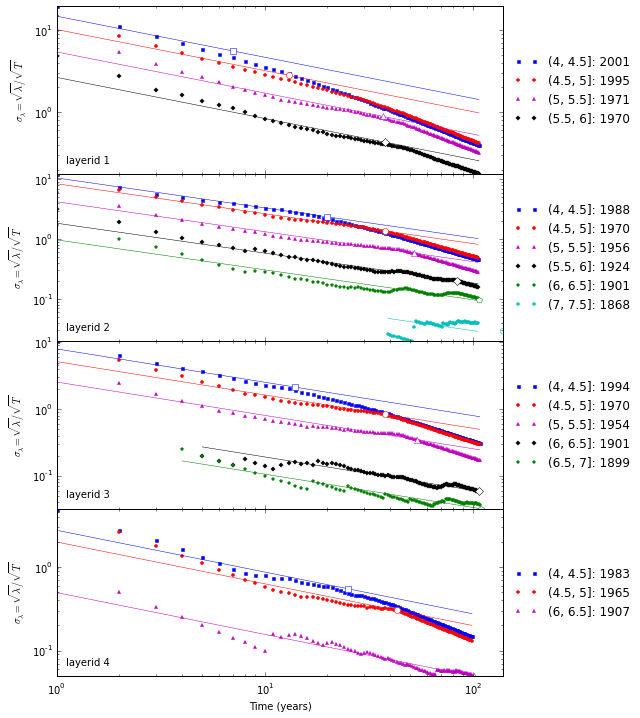

In [167]:
layer_completeness_tables = plot_completeness_slices(
    declustered2, 'layerid', layer_ids, mag_bin=0.5, deduplicate=True)
plt.savefig('Stepp completeness (declustered mainshocks).pdf', 
            dpi=300, bbox_inches='tight')

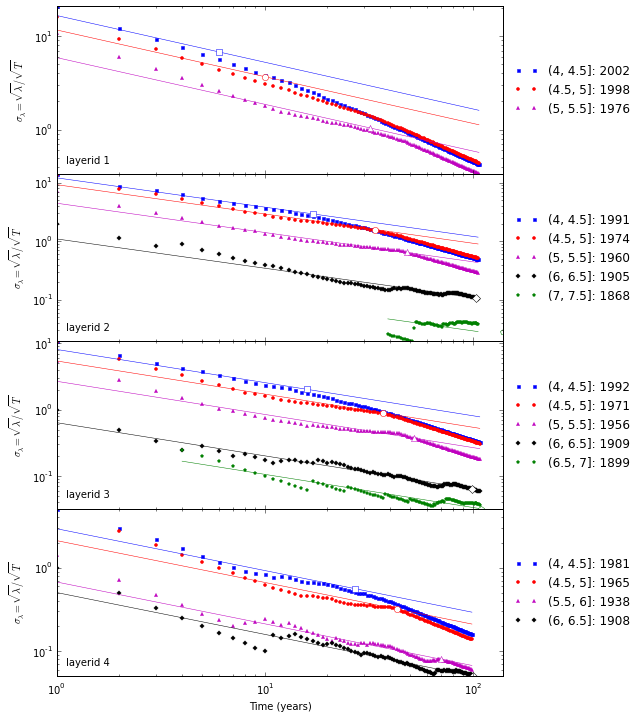

In [168]:
layer_completeness_tables = plot_completeness_slices(
    declustered3, 'layerid', layer_ids, mag_bin=0.5, deduplicate=True)
plt.savefig('Stepp completeness (declustered raw).pdf', 
            dpi=300, bbox_inches='tight')

In [ ]:
scp.plot_depth_histogram(declustered2, 5, normalisation=True)
plt.xlim(layer_depths_km[0], layer_depths_km[-1])
[plt.axvline(x, color='black', linestyle=':') for x in layer_depths_km];
plt.savefig('Depth histogram (declustered mainshocks).pdf', dpi=300, bbox_inches='tight')

In [ ]:
plot_magnitude_time_density_slices(declustered2, completeness_tables, 'layerid', layer_ids)
plt.savefig('Magnitude time density (declustered mainshocks).pdf', dpi=300, bbox_inches='tight')

In [ ]:
plot_magnitude_time_density_slices(declustered3, completeness_tables, 'layerid', layer_ids)
plt.savefig('Magnitude time density (declustered raw).pdf', dpi=300, bbox_inches='tight')

In [ ]:
catalogues = [catalogue, declustered, declustered2, declustered3]
names = ['raw', 'mainshocks', 'declustered mainshocks', 'declustered raw']
year_bin = 1

df_poisson = pd.DataFrame(columns=['best catalogue', 'layerid', 'min mag', 'start', 
                                   'events', 'years', 'activity rate', 
                                   'DT', 'BZ', "KSE'", 'KSU', 'all', 'w/o BZ'])
score = df_poisson.columns[-1]

for layer_id, completeness_tables_layer in zip(layer_ids, completeness_tables):
    for completeness_table in completeness_tables_layer:
        for cat, name in zip(catalogues, names):

            start_year = completeness_table[0][0]
            min_mag = completeness_table[0][1]
            df_catalogue = pd.DataFrame(cat.data)
            df_catalogue['t'] = cat.get_decimal_time()

            above_min = df_catalogue['magnitude'] >= min_mag
            in_years = df_catalogue['year'] >= start_year
            if layer_id == 'all':
                in_layer = np.full_like(in_years, True)
            else:
                in_layer = df_catalogue['layerid'] == layer_id

            t = df_catalogue[in_layer & in_years & above_min]['t']
            time_range = (int(start_year), np.ceil(catalogue.get_decimal_time().max()))
            duration =  time_range[1] - time_range[0]
            num_events = len(t)
            activity_rate = num_events/duration

            p_DT = poisson_test.dispersion(t, time_range) 
            p_BZ = poisson_test.brown_zhao(t, time_range)
            p_KSE2 = poisson_test.kolmogorov_smirnov(t, time_range, 'expon')
            p_KSU = poisson_test.kolmogorov_smirnov(t, time_range, 'uniform')
            p_DT_BZ_KSE2_KSU = poisson_test.combine_pvalues((p_DT, p_BZ, p_KSE2, p_KSU))[0]
            p_DT_KSE2_KSU = poisson_test.combine_pvalues((p_DT, p_KSE2, p_KSU))[0]

            result_list = [name, layer_id, min_mag, start_year, 
                           num_events, duration, activity_rate, 
                           p_DT, p_BZ, p_KSE2, p_KSU, 
                           p_DT_BZ_KSE2_KSU, p_DT_KSE2_KSU]
            result_series = pd.Series(result_list, index=df_poisson.columns)

            best_result = ((df_poisson['layerid'] == layer_id) &
                           (df_poisson['min mag'] == min_mag) &
                           (df_poisson['start'] == start_year))
            if not any(best_result.tolist()):
                df_poisson = df_poisson.append(result_series, ignore_index=True)
            else:
                if df_poisson[score][best_result].values[0] <= result_series[score]:
                    print('layer %d > M%g since %d: Dropping %s (%.3g) in favour of %s (%.3g)' %
                          (layer_id, min_mag, start_year,
                           df_poisson['best catalogue'][best_result].values[0], 
                           df_poisson[score][best_result].values[0],
                           name, result_series[score], ))
                    df_poisson.drop(np.where(best_result.values)[0], inplace=True)
                    df_poisson = df_poisson.append(result_series, ignore_index=True)
                else:
                    print('layer %d > M%g since %d: Keeping %s (%.3g) instead of %s (%.3g)' %
                          (layer_id, min_mag, start_year,
                           df_poisson['best catalogue'][best_result].values[0], 
                           df_poisson[score][best_result].values[0],
                           name, result_series[score], ))

df_poisson[['start', 'events', 'years']] = df_poisson[['start', 'events', 'years']].astype(int)
df_poisson

In [ ]:
df_poisson.to_csv('MostPoissonianSubcatalogues.csv')

In [ ]:
# compute smoothed-gridded seismicity - INTENSIVE!
grid_step = 0.2
grid_setup = [min_lon - grid_step/2., max_lon + grid_step/2., grid_step, 
              min_lat - grid_step/2., max_lat + grid_step/2., grid_step, 0., 1000., 1000.]  
smoother = SmoothedSeismicity(grid_setup, use_3d=False, bvalue=1.0)

for _, layer in df_layers.iterrows():
    for _, model in df_models.iterrows():
        kernel_config = {'Length_Limit': 3., 
                         'BandWidth': model['corr dist'], 
                         'increment': False}
        
        catalogue_layer = deepcopy(declustered)
        in_layer = catalogue_layer.data['layerid'] == layer['id']
        catalogue_layer.select_catalogue_events(in_layer)
        above_min = catalogue_layer.data['magnitude'] >= model['min mag']
        start_year = layer[str(model['min mag']) + ' start']
        end_year = layer[str(model['min mag']) + ' end']
        duration = end_year - start_year + 1
        print "Layer %d: %d events, %d with M >= %g or %.3g per year since %d" % (
            layer['id'], catalogue_layer.get_number_events(), 
            sum(above_min), model['min mag'], sum(above_min)/float(duration), start_year)
        
        # output file name
        large_csv = large_csv_template % (layer['id'], model['min mag'])                                      
        completeness_table = np.array([[start_year, model['min mag']]])
        output_data = smoother.run_analysis(
            catalogue_layer, kernel_config, completeness_table, 
            smoothing_kernel=IsotropicGaussian())
        print 'Writing output to "%s"' % large_csv
        smoother.write_to_csv(large_csv)
        print

In [ ]:
# do some filtering and reprocessing of smoothed seismicity
minimum = np.inf
maximum = 0
for min_mag in min_mags:
    for layer_id in layer_ids:
        
        large_csv = large_csv_template % (layer_id, min_mag)
        small_csv = small_csv_template % (min_mag, layer_id)
        old_txt = old_txt_template % (layer_id, min_mag)
        new_txt = new_txt_template % (layer_id, min_mag)
        
        # keep only points on the grid of the old model
        df_new = pd.read_csv(large_csv)
        df_old = pd.read_csv(old_txt)
        df_old.rename(columns={
                'latitude': 'Latitude', 'lat': 'Latitude', 
                'longitude': 'Longitude', 'lon': 'Longitude',
            }, inplace=True)
        df_new = pd.merge(df_old, df_new)
        
        # round the results
        df_new['Smoothed Rate'] = df_new['Smoothed Rate'].round(6)
        df_new = df_new[df_new['Smoothed Rate'] != 0]
        minimum = min(minimum, df_new['Smoothed Rate'].min())
        maximum = max(maximum, df_new['Smoothed Rate'].max())
        
        # get rid of uninteresting columns
        df_new.drop(['Depth', 'b-value'], axis=1, inplace=True)
        df_new.to_csv(small_csv, index=False)
        
        # also write new dataset in old format
        rename_cols = {'Smoothed Rate': 'nu', 'Latitude':'lat', 'Longitude': 'lon'}
        df_new.rename(columns=rename_cols, inplace=True)
        df_new = df_new[['lon', 'lat', 'nu']]
        df_new.to_csv(new_txt, index=False, sep=',', float_format='%g')
                      
limits = tb.stdval((minimum, maximum), 3)
print "limits", limits

In [ ]:
point_size = (grid_step/0.2)**2
map_config = {'min_lon': min_lon, 'max_lon': max_lon, 'min_lat': min_lat, 'max_lat': max_lat, 
              'parallel_meridian_spacing': 10, 'resolution':'l'}

fig, axes = plt.subplots(len(layer_ids), len(min_mags), figsize=(8,12), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)
for i, layer_id in enumerate(layer_ids):
    for j, min_mag in enumerate(min_mags):
        plt.sca(axes[i, j])
        tb.annotate('Layer %d: M > %g' % (layer_id, min_mag), 'lower left')

        small_csv = small_csv_template % (min_mag, layer_id)
        df = pd.read_csv(small_csv)
        basemap = HMTKBaseMap(map_config, None)
        basemap.add_colour_scaled_points(
            df['Longitude'].values, df['Latitude'].values, 
            df['Smoothed Rate'].values, size=point_size, alpha=1,
            norm=LogNorm(limits[0], limits[1]), overlay=True, add_colorbar=False)
        
fig.savefig('SmoothedRecalculated.png', dpi=300, bbox_inches='tight')

In [ ]:
fig, axes = plt.subplots(len(layer_ids), len(min_mags), 
                         figsize=(8,12), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'datalim', 'aspect': 1})
fig.subplots_adjust(hspace=0, wspace=0)
for i, layer_id in enumerate(layer_ids):
    for j, min_mag in enumerate(min_mags):
        plt.sca(axes[i, j])
        tb.annotate('Layer %d: M > %g' % (layer_id, min_mag), 'lower left')

        small_csv = small_csv_template % (min_mag, layer_id)

        df = pd.read_csv(small_csv)
        im = plt.scatter(df['Longitude'].values, df['Latitude'].values, 
                    c=df['Smoothed Rate'].values, s=point_size, marker='s', edgecolor='none', 
                    cmap='jet', norm=LogNorm(limits[0], limits[1]))
plt.gca().set_aspect('equal')
plt.autoscale(enable=True, axis=u'both', tight=True)
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5, 
             label=u'Events per year per %g° cell' % grid_step)
[ax.set_xlabel(u'Longitude [°]') for ax in axes[-1, :]]
[ax.xaxis.set_major_locator(MultipleLocator(base=10.)) for ax in axes[-1, :]]
[ax.set_ylabel(u'Latitude [°]') for ax in axes[:, 0]]
[ax.yaxis.set_major_locator(MultipleLocator(base=10.)) for ax in axes[:, 0]]

fig.savefig('SmoothedRecalculatedNoMap.pdf', dpi=300, bbox_inches='tight')

In [ ]:
fig, axes = plt.subplots(len(layer_ids), len(min_mags), 
                         figsize=(8,12), sharex=True, sharey=True,
                         subplot_kw={'adjustable': 'datalim', 'aspect': 1})
fig.subplots_adjust(hspace=0, wspace=0)
for i, layer in df_layers.iterrows():
    for j, model in df_models.iterrows():
        plt.sca(axes[i, j])
        tb.annotate('Layer %d: M > %g' % (layer['id'], model['min mag']), 'lower left')

        old_txt = old_txt_template % (layer['id'], model['min mag'])
         
        df = pd.read_csv(old_txt)
        df.rename(columns={'lat': 'latitude', 'lon': 'longitude'}, inplace=True)
        
        nu_mag = [item for item in df.keys() if 'nu' in item][0]
        start_year = layer[str(model['min mag']) + ' start']
        end_year = layer[str(model['min mag']) + ' end']
        old_step = np.mean(np.diff(sorted(list(set(df['latitude'])))))
        
        # convert from count to rate and from old grid to current
        equivalent_rate = df[nu_mag].values*(((grid_step/old_step)**2)/
                                             (end_year - start_year + 1))
        point_size = (old_step/0.2)**2
        im = plt.scatter(df['longitude'].values, df['latitude'].values, 
                    c=equivalent_rate, s=point_size, edgecolor='none',
                    cmap='jet', norm=LogNorm(limits[0], limits[1]))
        
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5, 
             label=u'Events per year per %g° cell' % grid_step)
[ax.set_xlabel(u'Longitude [°]') for ax in axes[-1, :]]
[ax.xaxis.set_major_locator(MultipleLocator(base=10.)) for ax in axes[-1, :]]
[ax.set_ylabel(u'Latitude [°]') for ax in axes[:, 0]]
[ax.yaxis.set_major_locator(MultipleLocator(base=10.)) for ax in axes[:, 0]]

fig.savefig('SmoothedThinbaigjamNoMap.pdf', dpi=300, bbox_inches='tight')

In [ ]:
c = 85  # km correlation distance
delta = 0.1  # grid spacing
span = 2.5  # test grid span
lon = 80  # degrees
lat = 20  # degrees
point = geo.Point(lon, lat)
lon_list = np.arange(lon - span, lon + span + delta/2, delta)
lat_list = np.arange(lat - span, lat + span + delta/2, delta)
lon_limits = (lon - span - delta/2, lon + span + delta/2)
lat_limits = (lat - span - delta/2, lat + span + delta/2)
lon_mesh, lat_mesh = np.meshgrid(lon_list, lat_list)
mesh = geo.RectangularMesh(lon_mesh, lat_mesh)
distances = point.distance_to_mesh(mesh)
i_mid = int(span/delta)
span_km = (distances[i_mid,:].max(), distances[:,i_mid].max())
print('Grid extents %g and %g km' % span_km)
print('Must be at least 3x correlation distance or %g km' % (3*c))
if all(np.array(span_km) > 3*c):
    print 'OK!'
else:
    print 'Problem!'
weights = np.exp(-(distances/c)**2) * (distances < 3*c)
print(u'For correlation distance %g km and grid spacing %g°' % (c, delta))
print('the unnormalized weights sum to %g.' % weights.sum())

In [ ]:
plt.imshow(distances, origin='lower', aspect='equal', 
           interpolation='nearest', 
           extent=lon_limits + lat_limits)
plt.title('Test grid to compute smoothing normalization')
plt.xlabel(u'Longitude (°E)')
plt.ylabel(u'Latitude (°N)')
plt.grid()
plt.colorbar();

In [ ]:
plt.imshow(weights, cmap='hot', origin='lower', aspect='equal', 
           interpolation='nearest', 
           extent=lon_limits + lat_limits)
plt.title('Weights on test grid')
plt.xlabel(u'Longitude (°E)')
plt.ylabel(u'Latitude (°N)')
plt.grid()
plt.colorbar();